In [1]:
%load_ext autoreload
%autoreload 2

import gc
import warnings

import scipy as sp
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict, Counter
import random
import os

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from catboost import CatBoostClassifier
from sklearn.decomposition import PCA

import sys
sys.path.append("..")
from src import *

warnings.filterwarnings('ignore')

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
%%time
train = pd.read_parquet("../tmp/train_agg.parquet")
train

CPU times: user 16.3 s, sys: 13.8 s, total: 30.1 s
Wall time: 16.9 s


,customer_ID,D_50_last_2m,D_50_first_2m,D_50_mean_2m,D_50_std_2m,D_50_min_2m,D_50_max_2m,R_17_last_2m,R_17_first_2m,R_17_mean_2m,R_17_std_2m,R_17_min_2m,R_17_max_2m,B_39_last_2m,B_39_first_2m,B_39_mean_2m,B_39_std_2m,B_39_min_2m,B_39_max_2m,S_26_last_2m,S_26_first_2m,S_26_mean_2m,S_26_std_2m,S_26_min_2m,S_26_max_2m,D_39_last_2m,D_39_first_2m,D_39_mean_2m,D_39_std_2m,D_39_min_2m,D_39_max_2m,D_75_last_2m,D_75_first_2m,D_75_mean_2m,D_75_std_2m,D_75_min_2m,D_75_max_2m,R_10_last_2m,R_10_first_2m,R_10_mean_2m,R_10_std_2m,R_10_min_2m,R_10_max_2m,R_27_last_2m,R_27_first_2m,R_27_mean_2m,R_27_std_2m,R_27_min_2m,R_27_max_2m,B_17_last_2m,B_17_first_2m,B_17_mean_2m,B_17_std_2m,B_17_min_2m,B_17_max_2m,R_18_last_2m,R_18_first_2m,R_18_mean_2m,R_18_std_2m,R_18_min_2m,R_18_max_2m,R_24_last_2m,R_24_first_2m,R_24_mean_2m,R_24_std_2m,R_24_min_2m,R_24_max_2m,S_6_last_2m,S_6_first_2m,S_6_mean_2m,S_6_std_2m,S_6_min_2m,S_6_max_2m,D_104_last_2m,D_104_first_2m,D_104_mean_2m,D_104_std_2m,D_104_min_2m,D_104_max_2m,D_141_last_2m,D_141_first_2m,D_141_mean_2m,D_141_std_2m,D_141_min_2m,D_141_max_2m,B_11_last_2m,B_11_first_2m,B_11_mean_2m,B_11_std_2m,B_11_min_2m,B_11_max_2m,R_23_last_2m,R_23_first_2m,R_23_mean_2m,R_23_std_2m,R_23_min_2m,R_23_max_2m,B_5_last_2m,B_5_first_2m,B_5_mean_2m,B_5_std_2m,B_5_min_2m,B_5_max_2m,B_19_last_2m,B_19_first_2m,B_19_mean_2m,B_19_std_2m,B_19_min_2m,B_19_max_2m,D_53_last_2m,D_53_first_2m,D_53_mean_2m,D_53_std_2m,D_53_min_2m,D_53_max_2m,D_88_last_2m,D_88_first_2m,D_88_mean_2m,D_88_std_2m,D_88_min_2m,D_88_max_2m,R_2_last_2m,R_2_first_2m,R_2_mean_2m,R_2_std_2m,R_2_min_2m,R_2_max_2m,R_6_last_2m,R_6_first_2m,R_6_mean_2m,R_6_std_2m,R_6_min_2m,R_6_max_2m,D_111_last_2m,D_111_first_2m,D_111_mean_2m,D_111_std_2m,D_111_min_2m,D_111_max_2m,D_110_last_2m,D_110_first_2m,D_110_mean_2m,D_110_std_2m,D_110_min_2m,D_110_max_2m,D_72_last_2m,D_72_first_2m,D_72_mean_2m,D_72_std_2m,D_72_min_2m,D_72_max_2m,B_41_last_2m,B_41_first_2m,B_41_mean_2m,B_41_std_2m,B_41_min_2m,B_41_max_2m,B_21_last_2m,B_21_first_2m,B_21_mean_2m,B_21_std_2m,B_21_min_2m,B_21_max_2m,R_13_last_2m,R_13_first_2m,R_13_mean_2m,R_13_std_2m,R_13_min_2m,R_13_max_2m,D_140_last_2m,D_140_first_2m,D_140_mean_2m,D_140_std_2m,D_140_min_2m,D_140_max_2m,D_61_last_2m,D_61_first_2m,D_61_mean_2m,D_61_std_2m,D_61_min_2m,D_61_max_2m,R_20_last_2m,R_20_first_2m,R_20_mean_2m,R_20_std_2m,R_20_min_2m,R_20_max_2m,R_21_last_2m,R_21_first_2m,R_21_mean_2m,R_21_std_2m,R_21_min_2m,R_21_max_2m,D_54_last_2m,D_54_first_2m,D_54_mean_2m,D_54_std_2m,D_54_min_2m,D_54_max_2m,D_48_last_2m,D_48_first_2m,D_48_mean_2m,D_48_std_2m,D_48_min_2m,D_48_max_2m,D_131_last_2m,D_131_first_2m,D_131_mean_2m,D_131_std_2m,D_131_min_2m,D_131_max_2m,B_9_last_2m,B_9_first_2m,B_9_mean_2m,B_9_std_2m,B_9_min_2m,B_9_max_2m,S_19_last_2m,S_19_first_2m,S_19_mean_2m,S_19_std_2m,S_19_min_2m,S_19_max_2m,B_40_last_2m,B_40_first_2m,B_40_mean_2m,B_40_std_2m,B_40_min_2m,B_40_max_2m,S_5_last_2m,S_5_first_2m,S_5_mean_2m,S_5_std_2m,S_5_min_2m,S_5_max_2m,D_142_last_2m,D_142_first_2m,D_142_mean_2m,D_142_std_2m,D_142_min_2m,D_142_max_2m,S_15_last_2m,S_15_first_2m,S_15_mean_2m,S_15_std_2m,S_15_min_2m,S_15_max_2m,D_60_last_2m,D_60_first_2m,D_60_mean_2m,...,D_96_last_std_diff_6m,D_96_last_min_diff_6m,D_96_last_max_diff_6m,R_3_last_first_diff_2m,R_3_last_mean_diff_2m,R_3_last_std_diff_2m,R_3_last_min_diff_2m,R_3_last_max_diff_2m,R_3_last_first_diff_6m,R_3_last_mean_diff_6m,R_3_last_std_diff_6m,R_3_last_min_diff_6m,R_3_last_max_diff_6m,D_51_last_first_diff_2m,D_51_last_mean_diff_2m,D_51_last_std_diff_2m,D_51_last_min_diff_2m,D_51_last_max_diff_2m,D_51_last_first_diff_6m,D_51_last_mean_diff_6m,D_51_last_std_diff_6m,D_51_last_min_diff_6m,D_51_last_max_diff_6m,B_31_last_first_diff_2m,B_31_last_mean_diff_2m,B_31_last_std_diff_2m,B_31_last_min_diff_2m,B_31_last_max_diff_2m,B_31_last_first_diff_6m,B_31_last_mean_diff_6m,B_31_last_std_diff_6m,B_31_last_min_diff_6m,B_31_last_max_diff_6m,P_3_last_first_diff_2m,P_3_last_mean_diff_2m,P_3_last_std_diff_2m,P_3_last_min_diff_2m,

In [3]:
class CFG:
    missing_threshold = 0.7
    correlation_threshold = 0.95

In [4]:
features = AmexFeatures()

# Пропущенные значения 

In [5]:
fs = FeatureSelector(data=train[features.get_numeric(train)], 
                     labels=train["target"])
fs.identify_missing(missing_threshold = CFG.missing_threshold)
missing_features = fs.ops['missing']

755 features with greater than 0.70 missing values.



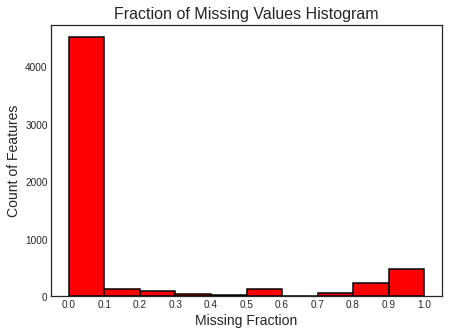

In [6]:
fs.plot_missing()

In [7]:
train.drop(missing_features, axis=1, inplace=True)
train

,customer_ID,D_50_last_2m,D_50_first_2m,D_50_mean_2m,D_50_std_2m,D_50_min_2m,D_50_max_2m,R_17_last_2m,R_17_first_2m,R_17_mean_2m,R_17_std_2m,R_17_min_2m,R_17_max_2m,S_26_last_2m,S_26_first_2m,S_26_mean_2m,S_26_std_2m,S_26_min_2m,S_26_max_2m,D_39_last_2m,D_39_first_2m,D_39_mean_2m,D_39_std_2m,D_39_min_2m,D_39_max_2m,D_75_last_2m,D_75_first_2m,D_75_mean_2m,D_75_std_2m,D_75_min_2m,D_75_max_2m,R_10_last_2m,R_10_first_2m,R_10_mean_2m,R_10_std_2m,R_10_min_2m,R_10_max_2m,R_27_last_2m,R_27_first_2m,R_27_mean_2m,R_27_std_2m,R_27_min_2m,R_27_max_2m,B_17_last_2m,B_17_first_2m,B_17_mean_2m,B_17_std_2m,B_17_min_2m,B_17_max_2m,R_18_last_2m,R_18_first_2m,R_18_mean_2m,R_18_std_2m,R_18_min_2m,R_18_max_2m,R_24_last_2m,R_24_first_2m,R_24_mean_2m,R_24_std_2m,R_24_min_2m,R_24_max_2m,S_6_last_2m,S_6_first_2m,S_6_mean_2m,S_6_std_2m,S_6_min_2m,S_6_max_2m,D_104_last_2m,D_104_first_2m,D_104_mean_2m,D_104_std_2m,D_104_min_2m,D_104_max_2m,D_141_last_2m,D_141_first_2m,D_141_mean_2m,D_141_std_2m,D_141_min_2m,D_141_max_2m,B_11_last_2m,B_11_first_2m,B_11_mean_2m,B_11_std_2m,B_11_min_2m,B_11_max_2m,R_23_last_2m,R_23_first_2m,R_23_mean_2m,R_23_std_2m,R_23_min_2m,R_23_max_2m,B_5_last_2m,B_5_first_2m,B_5_mean_2m,B_5_std_2m,B_5_min_2m,B_5_max_2m,B_19_last_2m,B_19_first_2m,B_19_mean_2m,B_19_std_2m,B_19_min_2m,B_19_max_2m,R_2_last_2m,R_2_first_2m,R_2_mean_2m,R_2_std_2m,R_2_min_2m,R_2_max_2m,R_6_last_2m,R_6_first_2m,R_6_mean_2m,R_6_std_2m,R_6_min_2m,R_6_max_2m,D_72_last_2m,D_72_first_2m,D_72_mean_2m,D_72_std_2m,D_72_min_2m,D_72_max_2m,B_41_last_2m,B_41_first_2m,B_41_mean_2m,B_41_std_2m,B_41_min_2m,B_41_max_2m,B_21_last_2m,B_21_first_2m,B_21_mean_2m,B_21_std_2m,B_21_min_2m,B_21_max_2m,R_13_last_2m,R_13_first_2m,R_13_mean_2m,R_13_std_2m,R_13_min_2m,R_13_max_2m,D_140_last_2m,D_140_first_2m,D_140_mean_2m,D_140_std_2m,D_140_min_2m,D_140_max_2m,D_61_last_2m,D_61_first_2m,D_61_mean_2m,D_61_std_2m,D_61_min_2m,D_61_max_2m,R_20_last_2m,R_20_first_2m,R_20_mean_2m,R_20_std_2m,R_20_min_2m,R_20_max_2m,R_21_last_2m,R_21_first_2m,R_21_mean_2m,R_21_std_2m,R_21_min_2m,R_21_max_2m,D_54_last_2m,D_54_first_2m,D_54_mean_2m,D_54_std_2m,D_54_min_2m,D_54_max_2m,D_48_last_2m,D_48_first_2m,D_48_mean_2m,D_48_std_2m,D_48_min_2m,D_48_max_2m,D_131_last_2m,D_131_first_2m,D_131_mean_2m,D_131_std_2m,D_131_min_2m,D_131_max_2m,B_9_last_2m,B_9_first_2m,B_9_mean_2m,B_9_std_2m,B_9_min_2m,B_9_max_2m,S_19_last_2m,S_19_first_2m,S_19_mean_2m,S_19_std_2m,S_19_min_2m,S_19_max_2m,B_40_last_2m,B_40_first_2m,B_40_mean_2m,B_40_std_2m,B_40_min_2m,B_40_max_2m,S_5_last_2m,S_5_first_2m,S_5_mean_2m,S_5_std_2m,S_5_min_2m,S_5_max_2m,S_15_last_2m,S_15_first_2m,S_15_mean_2m,S_15_std_2m,S_15_min_2m,S_15_max_2m,D_60_last_2m,D_60_first_2m,D_60_mean_2m,D_60_std_2m,D_60_min_2m,D_60_max_2m,R_8_last_2m,R_8_first_2m,R_8_mean_2m,R_8_std_2m,R_8_min_2m,R_8_max_2m,B_15_last_2m,B_15_first_2m,B_15_mean_2m,B_15_std_2m,B_15_min_2m,B_15_max_2m,B_10_last_2m,B_10_first_2m,B_10_mean_2m,B_10_std_2m,B_10_min_2m,B_10_max_2m,D_89_last_2m,D_89_first_2m,D_89_mean_2m,D_89_std_2m,D_89_min_2m,D_89_max_2m,R_28_last_2m,R_28_first_2m,R_28_mean_2m,R_28_std_2m,R_28_min_2m,R_28_max_2m,D_46_last_2m,D_46_first_2m,D_46_mean_2m,...,D_43_last_std_diff_6m,D_43_last_min_diff_6m,D_43_last_max_diff_6m,D_133_last_first_diff_2m,D_133_last_mean_diff_2m,D_133_last_std_diff_2m,D_133_last_min_diff_2m,D_133_last_max_diff_2m,D_133_last_first_diff_6m,D_133_last_mean_diff_6m,D_133_last_std_diff_6m,D_133_last_min_diff_6m,D_133_last_max_diff_6m,D_96_last_first_diff_2m,D_96_last_mean_diff_2m,D_96_last_std_diff_2m,D_96_last_min_diff_2m,D_96_last_max_diff_2m,D_96_last_first_diff_6m,D_96_last_mean_diff_6m,D_96_last_std_diff_6m,D_96_last_min_diff_6m,D_96_last_max_diff_6m,R_3_last_first_diff_2m,R_3_last_mean_diff_2m,R_3_last_std_diff_2m,R_3_last_min_diff_2m,R_3_last_max_diff_2m,R_3_last_first_diff_6m,R_3_last_mean_diff_6m,R_3_last_std_diff_6m,R_3_last_min_diff_6m,R_3_last_max_diff_6m,D_51_last_first_diff_2m,D_51_last_mean_diff_2m,D_51_last_std_diff_2m,D_51_last_min_diff_2m,D_51_last_

# Удаление полей с постоянным значением 

In [8]:
fs = FeatureSelector(data=train, labels=train["target"])
fs.identify_single_unique()
single_unique = fs.ops['single_unique']

12 features with a single unique value.



In [9]:
train.drop(single_unique, axis=1, inplace=True)
train

,customer_ID,D_50_last_2m,D_50_first_2m,D_50_mean_2m,D_50_std_2m,D_50_min_2m,D_50_max_2m,R_17_last_2m,R_17_first_2m,R_17_mean_2m,R_17_std_2m,R_17_min_2m,R_17_max_2m,S_26_last_2m,S_26_first_2m,S_26_mean_2m,S_26_std_2m,S_26_min_2m,S_26_max_2m,D_39_last_2m,D_39_first_2m,D_39_mean_2m,D_39_std_2m,D_39_min_2m,D_39_max_2m,D_75_last_2m,D_75_first_2m,D_75_mean_2m,D_75_std_2m,D_75_min_2m,D_75_max_2m,R_10_last_2m,R_10_first_2m,R_10_mean_2m,R_10_std_2m,R_10_min_2m,R_10_max_2m,R_27_last_2m,R_27_first_2m,R_27_mean_2m,R_27_std_2m,R_27_min_2m,R_27_max_2m,B_17_last_2m,B_17_first_2m,B_17_mean_2m,B_17_std_2m,B_17_min_2m,B_17_max_2m,R_18_last_2m,R_18_first_2m,R_18_mean_2m,R_18_std_2m,R_18_min_2m,R_18_max_2m,R_24_last_2m,R_24_first_2m,R_24_mean_2m,R_24_std_2m,R_24_min_2m,R_24_max_2m,S_6_last_2m,S_6_first_2m,S_6_mean_2m,S_6_std_2m,S_6_min_2m,S_6_max_2m,D_104_last_2m,D_104_first_2m,D_104_mean_2m,D_104_std_2m,D_104_min_2m,D_104_max_2m,D_141_last_2m,D_141_first_2m,D_141_mean_2m,D_141_std_2m,D_141_min_2m,D_141_max_2m,B_11_last_2m,B_11_first_2m,B_11_mean_2m,B_11_std_2m,B_11_min_2m,B_11_max_2m,R_23_last_2m,R_23_first_2m,R_23_mean_2m,R_23_std_2m,R_23_min_2m,R_23_max_2m,B_5_last_2m,B_5_first_2m,B_5_mean_2m,B_5_std_2m,B_5_min_2m,B_5_max_2m,B_19_last_2m,B_19_first_2m,B_19_mean_2m,B_19_std_2m,B_19_min_2m,B_19_max_2m,R_2_last_2m,R_2_first_2m,R_2_mean_2m,R_2_std_2m,R_2_min_2m,R_2_max_2m,R_6_last_2m,R_6_first_2m,R_6_mean_2m,R_6_std_2m,R_6_min_2m,R_6_max_2m,D_72_last_2m,D_72_first_2m,D_72_mean_2m,D_72_std_2m,D_72_min_2m,D_72_max_2m,B_41_last_2m,B_41_first_2m,B_41_mean_2m,B_41_std_2m,B_41_min_2m,B_41_max_2m,B_21_last_2m,B_21_first_2m,B_21_mean_2m,B_21_std_2m,B_21_min_2m,B_21_max_2m,R_13_last_2m,R_13_first_2m,R_13_mean_2m,R_13_std_2m,R_13_min_2m,R_13_max_2m,D_140_last_2m,D_140_first_2m,D_140_mean_2m,D_140_std_2m,D_140_min_2m,D_140_max_2m,D_61_last_2m,D_61_first_2m,D_61_mean_2m,D_61_std_2m,D_61_min_2m,D_61_max_2m,R_20_last_2m,R_20_first_2m,R_20_mean_2m,R_20_std_2m,R_20_min_2m,R_20_max_2m,R_21_last_2m,R_21_first_2m,R_21_mean_2m,R_21_std_2m,R_21_min_2m,R_21_max_2m,D_54_last_2m,D_54_first_2m,D_54_mean_2m,D_54_std_2m,D_54_min_2m,D_54_max_2m,D_48_last_2m,D_48_first_2m,D_48_mean_2m,D_48_std_2m,D_48_min_2m,D_48_max_2m,D_131_last_2m,D_131_first_2m,D_131_mean_2m,D_131_std_2m,D_131_min_2m,D_131_max_2m,B_9_last_2m,B_9_first_2m,B_9_mean_2m,B_9_std_2m,B_9_min_2m,B_9_max_2m,S_19_last_2m,S_19_first_2m,S_19_mean_2m,S_19_std_2m,S_19_min_2m,S_19_max_2m,B_40_last_2m,B_40_first_2m,B_40_mean_2m,B_40_std_2m,B_40_min_2m,B_40_max_2m,S_5_last_2m,S_5_first_2m,S_5_mean_2m,S_5_std_2m,S_5_min_2m,S_5_max_2m,S_15_last_2m,S_15_first_2m,S_15_mean_2m,S_15_std_2m,S_15_min_2m,S_15_max_2m,D_60_last_2m,D_60_first_2m,D_60_mean_2m,D_60_std_2m,D_60_min_2m,D_60_max_2m,R_8_last_2m,R_8_first_2m,R_8_mean_2m,R_8_std_2m,R_8_min_2m,R_8_max_2m,B_15_last_2m,B_15_first_2m,B_15_mean_2m,B_15_std_2m,B_15_min_2m,B_15_max_2m,B_10_last_2m,B_10_first_2m,B_10_mean_2m,B_10_std_2m,B_10_min_2m,B_10_max_2m,D_89_last_2m,D_89_first_2m,D_89_mean_2m,D_89_std_2m,D_89_min_2m,D_89_max_2m,R_28_last_2m,R_28_first_2m,R_28_mean_2m,R_28_std_2m,R_28_min_2m,R_28_max_2m,D_46_last_2m,D_46_first_2m,D_46_mean_2m,...,D_78_last_first_diff_6m,D_78_last_mean_diff_6m,D_78_last_std_diff_6m,D_78_last_min_diff_6m,D_78_last_max_diff_6m,D_43_last_first_diff_2m,D_43_last_mean_diff_2m,D_43_last_std_diff_2m,D_43_last_min_diff_2m,D_43_last_max_diff_2m,D_43_last_first_diff_6m,D_43_last_mean_diff_6m,D_43_last_std_diff_6m,D_43_last_min_diff_6m,D_43_last_max_diff_6m,D_133_last_first_diff_2m,D_133_last_mean_diff_2m,D_133_last_std_diff_2m,D_133_last_min_diff_2m,D_133_last_max_diff_2m,D_133_last_first_diff_6m,D_133_last_mean_diff_6m,D_133_last_std_diff_6m,D_133_last_min_diff_6m,D_133_last_max_diff_6m,D_96_last_first_diff_2m,D_96_last_mean_diff_2m,D_96_last_std_diff_2m,D_96_last_min_diff_2m,D_96_last_max_diff_2m,D_96_last_first_diff_6m,D_96_last_mean_diff_6m,D_96_last_std_diff_6m,D_96_last_min_diff_6m,D_96_last_max_diff_6m,R_3_last_first_diff_2m,R_3_last_mean_diff_2m

# Cкорелированность признаков

In [10]:
num_features = list(set(["_".join(col.split("_")[:2]) for col in features.get_numeric(train)]))
len(num_features)

154

In [11]:
collinear_features_all = []
for feature in tqdm(num_features):
    cols = [col for col in train.columns if feature + "_" in col]

    fs = FeatureSelector(data=train[cols], labels=train["target"])
    fs.identify_collinear(correlation_threshold = CFG.correlation_threshold)
    
    collinear_features_all.extend(fs.ops['collinear'])

  0%|          | 0/154 [00:00<?, ?it/s]

6 features with a correlation magnitude greater than 0.95.

12 features with a correlation magnitude greater than 0.95.

6 features with a correlation magnitude greater than 0.95.

4 features with a correlation magnitude greater than 0.95.

7 features with a correlation magnitude greater than 0.95.

12 features with a correlation magnitude greater than 0.95.

10 features with a correlation magnitude greater than 0.95.

3 features with a correlation magnitude greater than 0.95.

14 features with a correlation magnitude greater than 0.95.

9 features with a correlation magnitude greater than 0.95.

10 features with a correlation magnitude greater than 0.95.

6 features with a correlation magnitude greater than 0.95.

6 features with a correlation magnitude greater than 0.95.

6 features with a correlation magnitude greater than 0.95.

8 features with a correlation magnitude greater than 0.95.

10 features with a correlation magnitude greater than 0.95.

11 features with a correlation mag

7 features with a correlation magnitude greater than 0.95.

8 features with a correlation magnitude greater than 0.95.

8 features with a correlation magnitude greater than 0.95.

10 features with a correlation magnitude greater than 0.95.

4 features with a correlation magnitude greater than 0.95.

6 features with a correlation magnitude greater than 0.95.

5 features with a correlation magnitude greater than 0.95.

5 features with a correlation magnitude greater than 0.95.

16 features with a correlation magnitude greater than 0.95.

11 features with a correlation magnitude greater than 0.95.

13 features with a correlation magnitude greater than 0.95.

6 features with a correlation magnitude greater than 0.95.

12 features with a correlation magnitude greater than 0.95.

11 features with a correlation magnitude greater than 0.95.

5 features with a correlation magnitude greater than 0.95.

10 features with a correlation magnitude greater than 0.95.

12 features with a correlation ma

In [12]:
len(collinear_features_all)

1315

In [13]:
counter = Counter()

for feature in collinear_features_all:
    counter["_".join(feature.split("_")[2:-1])] += 1
list(sorted(counter.items(), key=lambda x: -x[1]))

[('max', 238),
 ('mean', 177),
 ('last_std_diff', 168),
 ('min', 162),
 ('last_mean_diff', 160),
 ('last', 153),
 ('last_min_ratio', 137),
 ('first', 68),
 ('last_min_diff', 25),
 ('last_max_diff', 14),
 ('last_first_diff', 5),
 ('std', 4),
 ('last_std_ratio', 2),
 ('last_max_ratio', 2)]

In [14]:
train.drop(collinear_features_all, axis=1, inplace=True)
train

,customer_ID,D_50_last_2m,D_50_std_2m,R_17_last_2m,R_17_first_2m,R_17_mean_2m,R_17_std_2m,R_17_min_2m,S_26_last_2m,S_26_std_2m,D_39_last_2m,D_39_first_2m,D_39_mean_2m,D_39_std_2m,D_39_min_2m,D_75_last_2m,D_75_std_2m,R_10_last_2m,R_10_first_2m,R_10_mean_2m,R_10_std_2m,R_10_min_2m,R_27_last_2m,R_27_std_2m,B_17_last_2m,B_17_first_2m,B_17_mean_2m,B_17_std_2m,R_18_last_2m,R_18_first_2m,R_18_mean_2m,R_18_std_2m,R_18_min_2m,R_18_max_2m,R_24_last_2m,R_24_first_2m,R_24_mean_2m,R_24_std_2m,R_24_min_2m,R_24_max_2m,S_6_last_2m,S_6_first_2m,S_6_std_2m,D_104_last_2m,D_104_std_2m,D_141_last_2m,D_141_std_2m,B_11_last_2m,B_11_std_2m,R_23_last_2m,R_23_first_2m,R_23_mean_2m,R_23_std_2m,B_5_last_2m,B_5_first_2m,B_5_mean_2m,B_5_std_2m,B_5_min_2m,B_19_last_2m,B_19_std_2m,R_2_last_2m,R_2_first_2m,R_2_mean_2m,R_2_std_2m,R_2_min_2m,R_2_max_2m,R_6_last_2m,R_6_first_2m,R_6_mean_2m,R_6_std_2m,R_6_min_2m,D_72_last_2m,D_72_first_2m,D_72_std_2m,B_41_last_2m,B_41_first_2m,B_41_std_2m,B_21_last_2m,B_21_first_2m,B_21_std_2m,R_13_last_2m,R_13_first_2m,R_13_mean_2m,R_13_std_2m,R_13_min_2m,D_140_last_2m,D_140_first_2m,D_140_std_2m,D_61_last_2m,D_61_first_2m,D_61_std_2m,R_20_last_2m,R_20_first_2m,R_20_mean_2m,R_20_std_2m,R_20_min_2m,R_21_last_2m,R_21_first_2m,R_21_std_2m,R_21_min_2m,D_54_last_2m,D_54_first_2m,D_54_std_2m,D_48_last_2m,D_48_std_2m,D_131_last_2m,D_131_std_2m,B_9_last_2m,B_9_first_2m,B_9_std_2m,S_19_last_2m,S_19_first_2m,S_19_mean_2m,S_19_std_2m,S_19_min_2m,S_19_max_2m,B_40_last_2m,B_40_first_2m,B_40_std_2m,B_40_min_2m,S_5_last_2m,S_5_first_2m,S_5_std_2m,S_15_last_2m,S_15_first_2m,S_15_mean_2m,S_15_std_2m,S_15_min_2m,S_15_max_2m,D_60_last_2m,D_60_first_2m,D_60_std_2m,R_8_last_2m,R_8_first_2m,R_8_mean_2m,R_8_std_2m,R_8_min_2m,B_15_last_2m,B_15_first_2m,B_15_std_2m,B_10_last_2m,B_10_first_2m,B_10_mean_2m,B_10_std_2m,B_10_min_2m,D_89_last_2m,D_89_first_2m,D_89_mean_2m,D_89_std_2m,D_89_min_2m,R_28_last_2m,R_28_first_2m,R_28_std_2m,D_46_last_2m,D_46_first_2m,D_46_mean_2m,D_46_std_2m,D_46_min_2m,D_46_max_2m,D_103_last_2m,D_103_std_2m,D_81_last_2m,D_81_first_2m,D_81_std_2m,B_18_last_2m,B_18_first_2m,B_18_std_2m,D_71_last_2m,D_71_first_2m,D_71_std_2m,D_107_last_2m,D_107_std_2m,D_124_last_2m,D_124_std_2m,D_91_last_2m,D_91_first_2m,D_91_std_2m,S_24_last_2m,S_24_first_2m,S_24_mean_2m,S_24_std_2m,S_24_min_2m,S_24_max_2m,D_94_last_2m,D_94_first_2m,D_94_mean_2m,D_94_std_2m,D_94_min_2m,D_69_last_2m,D_69_std_2m,B_22_last_2m,B_22_first_2m,B_22_std_2m,R_12_last_2m,R_12_first_2m,R_12_std_2m,D_112_last_2m,D_112_first_2m,D_112_std_2m,D_125_last_2m,D_125_first_2m,D_125_mean_2m,D_125_std_2m,D_125_min_2m,D_139_last_2m,D_139_std_2m,D_143_last_2m,D_143_std_2m,D_130_last_2m,D_130_std_2m,B_27_last_2m,B_27_first_2m,B_27_mean_2m,B_27_std_2m,B_27_min_2m,B_27_max_2m,B_37_last_2m,B_37_first_2m,B_37_std_2m,B_23_last_2m,B_23_first_2m,B_23_std_2m,D_115_last_2m,D_115_std_2m,D_118_last_2m,D_118_std_2m,R_25_last_2m,R_25_first_2m,R_25_mean_2m,R_25_std_2m,R_25_min_2m,R_25_max_2m,D_122_last_2m,D_122_first_2m,D_122_std_2m,B_32_last_2m,B_32_first_2m,B_32_std_2m,B_32_min_2m,S_12_last_2m,S_12_first_2m,S_12_mean_2m,S_12_std_2m,S_12_min_2m,P_2_last_2m,P_2_std_2m,S_3_last_2m,S_3_first_2m,S_3_std_2m,D_47_last_2m,...,R_22_last_first_diff_6m,R_22_last_mean_diff_6m,R_22_last_std_diff_6m,R_22_last_max_diff_6m,S_7_last_first_diff_2m,S_7_last_min_diff_2m,S_7_last_max_diff_2m,S_7_last_first_diff_6m,S_7_last_mean_diff_6m,S_7_last_min_diff_6m,S_7_last_max_diff_6m,S_18_last_std_diff_2m,S_18_last_min_diff_2m,S_18_last_first_diff_6m,S_18_last_mean_diff_6m,S_18_last_std_diff_6m,S_18_last_min_diff_6m,B_25_last_first_diff_2m,B_25_last_min_diff_2m,B_25_last_max_diff_2m,B_25_last_first_diff_6m,B_25_last_mean_diff_6m,B_25_last_min_diff_6m,B_25_last_max_diff_6m,B_36_last_first_diff_2m,B_36_last_min_diff_2m,B_36_last_max_diff_2m,B_36_last_first_diff_6m,B_36_last_mean_diff_6m,B_36_last_std_diff_6m,B_36_last_min_diff_6m,B_36_last_max_diff_6m,B_24_last_first_diff_2m,B_24_last_std_diff_2m,B_24_last_min_diff_2m,B_24_last_max

# Скорелированность функций агрегаций и месяцев

In [15]:
agg_func = list(set(["_".join(col.split("_")[2:]) for col in train.columns[1:-1]]))
len(agg_func)

33

In [16]:
collinear_features_all = []
for func in tqdm(agg_func):
    cols = [col for col in features.get_numeric(train) if ("_".join(col.split("_")[2:]) == func)]

    fs = FeatureSelector(data=train[cols], labels=train["target"])
    fs.identify_collinear(correlation_threshold = CFG.correlation_threshold)
    
    collinear_features_all.extend(fs.ops['collinear'])

  0%|          | 0/33 [00:00<?, ?it/s]

2 features with a correlation magnitude greater than 0.95.

1 features with a correlation magnitude greater than 0.95.

9 features with a correlation magnitude greater than 0.95.

0 features with a correlation magnitude greater than 0.95.

0 features with a correlation magnitude greater than 0.95.

0 features with a correlation magnitude greater than 0.95.

0 features with a correlation magnitude greater than 0.95.

0 features with a correlation magnitude greater than 0.95.

8 features with a correlation magnitude greater than 0.95.

0 features with a correlation magnitude greater than 0.95.

1 features with a correlation magnitude greater than 0.95.

8 features with a correlation magnitude greater than 0.95.

1 features with a correlation magnitude greater than 0.95.

6 features with a correlation magnitude greater than 0.95.

1 features with a correlation magnitude greater than 0.95.

0 features with a correlation magnitude greater than 0.95.

0 features with a correlation magnitude 

In [21]:
len(collinear_features_all)

100

In [ ]:
train.drop(collinear_features_all, axis=1, inplace=True)
train

### Анализ 

In [23]:
counter = Counter()

for feature in train.columns[1:-1].tolist():
    counter["_".join(feature.split("_")[2:-1])] += 1
list(sorted(counter.items(), key=lambda x: -x[1]))

[('last_first_ratio', 307),
 ('last_mean_ratio', 307),
 ('last_max_ratio', 305),
 ('last_std_ratio', 304),
 ('last_first_diff', 286),
 ('std', 285),
 ('last_max_diff', 277),
 ('last_min_diff', 266),
 ('first', 248),
 ('last_min_ratio', 170),
 ('last', 162),
 ('min', 143),
 ('last_mean_diff', 139),
 ('last_std_diff', 136),
 ('mean', 128),
 ('max', 67),
 ('median', 18)]

In [24]:
counter = Counter()

for feature in train.columns[1:-1].tolist():
    counter["_".join(feature.split("_")[-1:])] += 1
list(sorted(counter.items(), key=lambda x: -x[1]))

[('6m', 1909), ('2m', 1639)]

# Сохранение результатов 

In [25]:
cols = train.columns[1:-1].tolist()

In [26]:
with open("../tmp/selected_features_step1.pickle", "bw") as f:
    pickle.dump(cols, f)